In [8]:
import numpy as np
import random as rn
rn.seed(0)
import numpy.random as npr
npr.seed(0)
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scanpy.external as sce

%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from scipy.sparse import csr_matrix

mtx = pd.read_csv('./data/GSE112013_Combined_UMI_table.txt.gz',sep='\t',index_col=0,engine='c')
barcodes = mtx.columns
genes = mtx.index
mtx = csr_matrix(mtx.values.T)
mtx.eliminate_zeros()
mtx.shape

(6490, 27477)

In [10]:
adata = sc.AnnData(mtx)
adata.obs_names = barcodes
adata.var_names = genes
adata.obs['Donor'] = adata.obs.index.map(lambda s: s.split('-')[0])

sc.pp.filter_genes(adata, min_cells=5)

sc.pp.normalize_total(adata)

adata.raw = adata

sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata,n_top_genes=5000)

adata

AnnData object with n_obs × n_vars = 6490 × 26266
    obs: 'Donor'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [11]:
sc.tl.pca(adata,use_highly_variable=True)
sce.pp.bbknn(adata,batch_key='Donor')
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=1.0)

In [12]:
# markers I used, from https://www.nature.com/articles/s41422-018-0099-2.pdf
# myoid: ACTA2
# sertoli: SOX9
# leydig: DLK1
# endothelial: VWF
# late primary: SPO11
# round: SPAG6
# elongated: CREM

cell_types = {
    '11': 'myoid cells',
    '19': 'sertoli cells',
    '0': 'leydig cells',
    '7': 'endothelial cells',
    '8': 'macrophages',
    '13': 'spermatogonial stem cells',
    '9': 'differentiating spermatogonia',
    '9': 'early primary spermatocytes',
    '15': 'early primary spermatocytes',
    '10': 'late primary spermatocytes',
    '17': 'late primary spermatocytes',
    '16': 'round spermatids',
    '18': 'round spermatids',
    '3': 'elongated spermatids',
    '6': 'elongated spermatids',
    '12':'sperm cells',
    '2':'sperm cells',
    '5':'sperm cells',
    '1':'sperm cells',
    '4':'sperm cells',
    '20':'sperm cells',
    '14':'sperm cells',
}

adata.obs['cell_type'] = adata.obs['leiden'].map(cell_types)

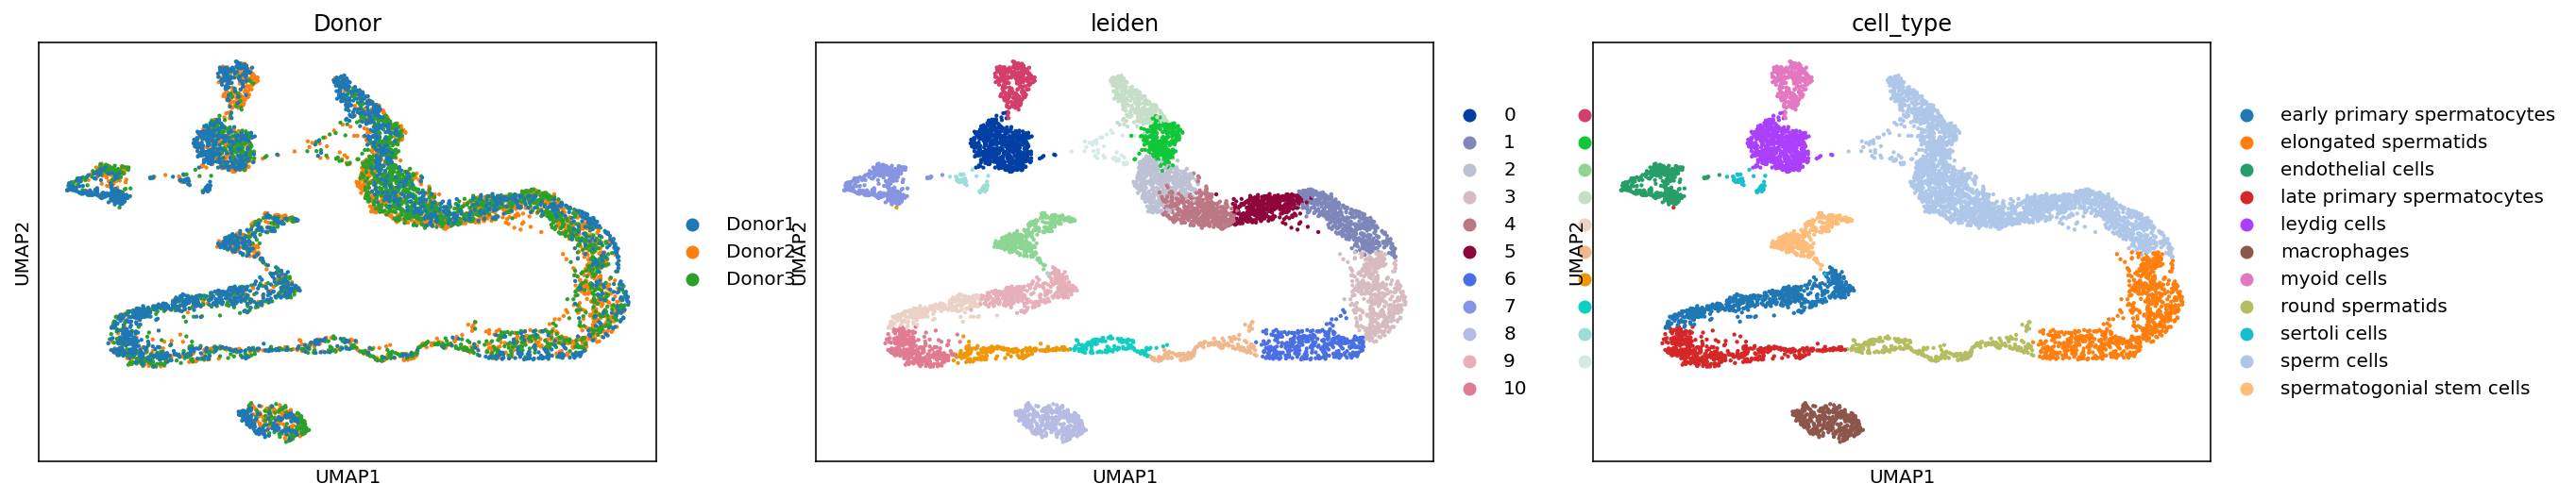

In [21]:
sc.pl.umap(adata,color=['Donor','leiden','cell_type'])

In [20]:
adata.write('./data/testis.h5')

In [22]:
specificity = adata.raw.to_adata().to_df().groupby(adata.obs['cell_type']).mean().T 
specificity += 1 / adata.shape[0] # pseudocount
specificity.values[:] = specificity.values / specificity.values.sum(1,keepdims=True)

specificity.to_csv('./data/testis_rna.csv')

specificity.shape

(26266, 11)